In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten, Dropout


In [2]:

data_dir = 'D:\\Private\\CODE\\kaggle\\image_colorization\\new_data'


In [3]:
batch_size = 16
img_height = 128
img_width = 128

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10157 files belonging to 5 classes.
Using 8126 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10157 files belonging to 5 classes.
Using 2031 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

num_classes = len(class_names)

['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']


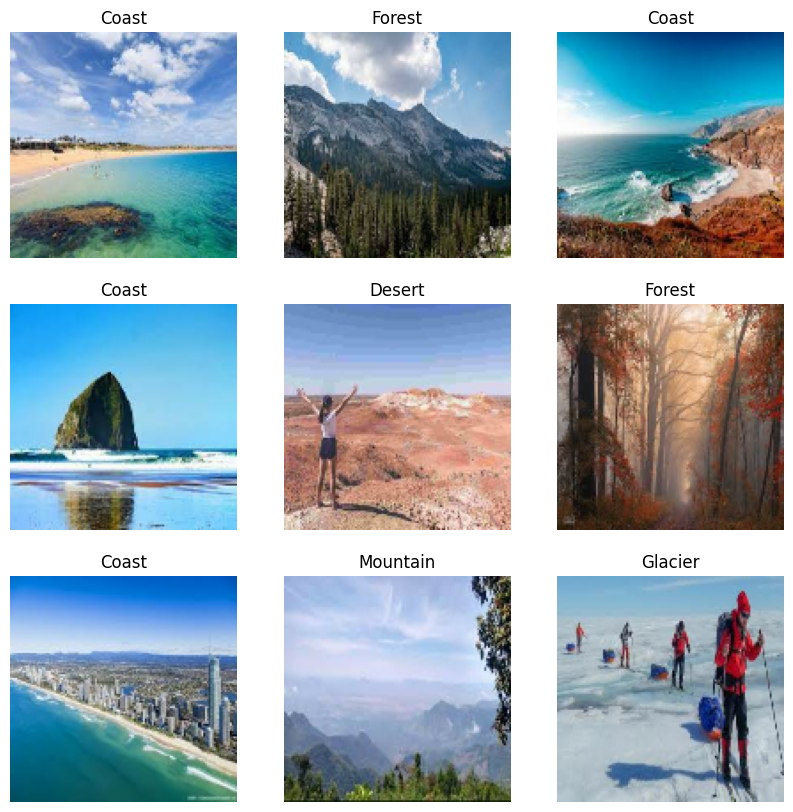

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 128, 128, 3)
(16,)


In [9]:
normalization_layer = layers.Rescaling(1./255)

In [10]:
from tensorflow.keras.applications import MobileNetV2,ResNet50V2

In [11]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# Base model: ResNet50V2
base_model = ResNet50V2(weights='imagenet', 
                        input_shape=(img_height, img_height, 3), 
                        pooling='max', 
                        include_top=False)

# Đóng băng các lớp trong ResNet50V2
for layer in base_model.layers:
    layer.trainable = False

# Tích hợp mô hình
model = Sequential([
    data_augmentation,            # Data augmentation
    layers.Rescaling(1./255),     # Chuẩn hóa dữ liệu
    base_model,                   # Base model ResNet50V2
    layers.Flatten(),             # Flatten để chuyển thành vector
    layers.Dense(128, activation='relu'),  # Lớp Dense ẩn
    layers.Dense(num_classes)     # Lớp đầu ra
])

# Kiểm tra cấu trúc mô hình
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 23,827,717
Trainable params: 262,917
Non

In [20]:
def create_model():

    base_model = ResNet50V2(weights='imagenet', input_shape= ( 128,128,3),pooling='max', classes=labels, include_top=False )

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())

    model.add(Dense(256,activation = 'relu'))
    model.add(Dense(128,activation = 'relu'))
    model.add(Dense(64,activation = 'relu'))
    model.add(Dense(16,activation = 'relu'))
    model.add(Dense(num_classes, activation = 'softmax'))
    model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 16)                1040      
                                                                 
 dense_6 (Dense)             (None, 5)                

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:

with tf.device('/gpu:0'):
  epochs=30
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )
  model.save("./save_model/prediction/classification_labels.keras")


Epoch 1/30


d:\Private\New folder\anconda\envs\tensorflowgpu\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


508/508 [==============================] - 20s 32ms/step - loss: 2.9943 - accuracy: 0.1989 - val_loss: 1.6094 - val_accuracy: 0.2014
Epoch 2/30
159/508 [========>.....................] - ETA: 9s - loss: 1.6096 - accuracy: 0.2032

KeyboardInterrupt: 

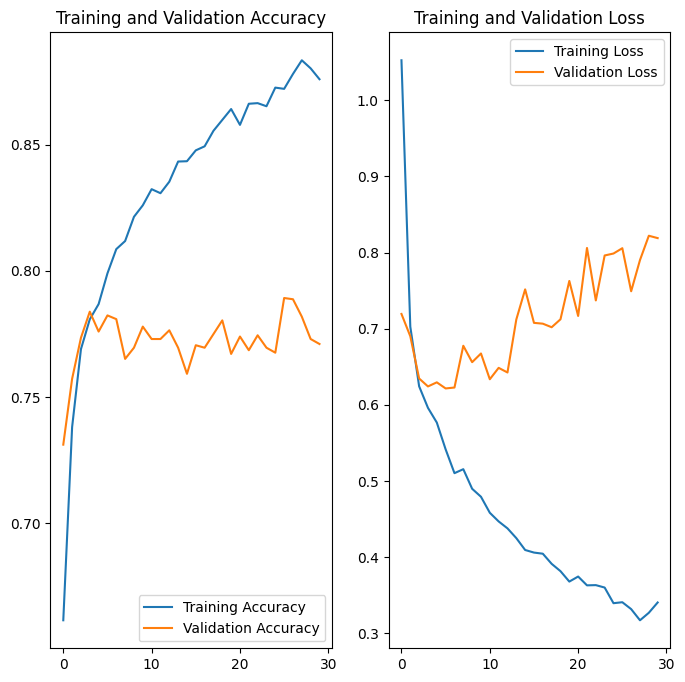

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
# classifier = tf.keras.models.load_model("D:\\Private\\CODE\\kaggle\\image_colorization\\save_model\\prediction\\classification_labels.keras")
# sunflower_path = '1.jpg'

In [17]:
class_names = ['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']


In [18]:

# img = tf.keras.utils.load_img(
#     sunflower_path, target_size=(img_height, img_width)
# )
# img_array = tf.keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = classifier.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )